In [2]:
import os
import numpy as np
from tqdm import tqdm


# Function to load data from a directory
def load_data(base_dir):
    gt_data = {}
    pred_data = {}

    # Walk through all subdirectories and files
    for root, _, files in tqdm(os.walk(base_dir)):
        for file in files:
            if file.endswith("_gt.npy") or file.endswith("_pred.npy"):
                # Extract information from the file path and name
                relative_path = os.path.relpath(root, base_dir)
                subject, action = relative_path.split(os.sep)[:2]
                file_id = file.split("_")[0]

                # Load the numpy file
                file_path = os.path.join(root, file)
                try:
                    data_array = np.load(file_path)
                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")
                    continue

                # Create dictionary key
                data_key = f"{subject}/{action}/{file_id}"

                # Store ground truth and prediction data
                if file.endswith("_gt.npy"):
                    gt_data[data_key] = data_array[0]
                else:
                    pred_data[data_key] = data_array[0]

    return gt_data, pred_data


# Example usage
base_directory = "output/MIA/mint_to_mia/4_trans_layers_256_width_28frames/muscle_activation/transformer/val"
gt_data, pred_data = load_data(base_directory)

# Print out some data to verify
for key in gt_data:
    print(f"GT {key}: {gt_data[key].shape}")
for key in pred_data:
    print(f"Pred {key}: {pred_data[key].shape}")

92it [00:14,  7.43it/s]

Failed to load output/MIA/mint_to_mia/4_trans_layers_256_width_28frames/muscle_activation/transformer/val/Subject4/JumpingJack/124_3051_pred.npy: No data left in file


145it [00:21,  6.85it/s]

GT Subject3/HighKick/221: (28, 8)
GT Subject3/HighKick/213: (28, 8)
GT Subject3/HighKick/211: (28, 8)
GT Subject3/HighKick/209: (28, 8)
GT Subject3/HighKick/215: (28, 8)
GT Subject3/HighKick/222: (28, 8)
GT Subject3/HighKick/226: (28, 8)
GT Subject3/HighKick/214: (28, 8)
GT Subject3/HighKick/224: (28, 8)
GT Subject3/HighKick/223: (28, 8)
GT Subject3/HighKick/225: (28, 8)
GT Subject3/HighKick/207: (28, 8)
GT Subject3/HighKick/212: (28, 8)
GT Subject3/HighKick/218: (28, 8)
GT Subject3/HighKick/217: (28, 8)
GT Subject3/HighKick/210: (28, 8)
GT Subject3/HighKick/219: (28, 8)
GT Subject3/HighKick/208: (28, 8)
GT Subject3/HighKick/220: (28, 8)
GT Subject3/HighKick/216: (28, 8)
GT Subject3/HookPunch/304: (28, 8)
GT Subject3/HookPunch/300: (28, 8)
GT Subject3/HookPunch/294: (28, 8)
GT Subject3/HookPunch/289: (28, 8)
GT Subject3/HookPunch/291: (28, 8)
GT Subject3/HookPunch/295: (28, 8)
GT Subject3/HookPunch/296: (28, 8)
GT Subject3/HookPunch/298: (28, 8)
GT Subject3/HookPunch/299: (28, 8)
GT Su

In [3]:
from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

MUSINT_402 = MUSCLE_SUBSETS["MUSINT_402"]

MIA_MUSCLES = [
    "quadriceps_femoris_l",
    "hamstring_l",
    "lateral_l",
    "biceps_l",
    "quadriceps_femoris_r",
    "hamstring_r",
    "lateral_r",
    "biceps_r",
]

MIA_SUBSET_TARGET = [
    "quadriceps_femoris_l",
    "hamstring_l",
    "quadriceps_femoris_r",
    "hamstring_r",
]

MIA_SUBSET = [
    [("quadriceps_femoris_l", 1.0)],
    [("hamstring_l", 1.0)],
    [("quadriceps_femoris_r", 1.0)],
    [("hamstring_r", 1.0)],
]

MUSINT_SUBSET = [
    [("LU_recfem_l", 1.0)],
    [("LU_bflh_l", 0.8), ("LU_bfsh_l", 0.2)],
    [("LU_recfem_r", 1.0)],
    [("LU_bflh_r", 1.0)],
]

In [4]:
import pandas as pd

gt_data_match = {k: pd.DataFrame(v, columns=MIA_MUSCLES)[MIA_SUBSET_TARGET] for k, v in gt_data.items()}
pred_data_n = {k: pd.DataFrame(v, columns=MUSINT_402) for k, v in pred_data.items()}

In [5]:
# Define the mappings for averaging
average_mapping = {
    "quadriceps_femoris_l": ["LU_recfem_l", "LU_vasint_l", "LU_vaslat_l", "LU_vasmed_l"],
    "hamstring_l": ["LU_bflh_l", "LU_bfsh_l", "LU_semimem_l", "LU_semiten_l"],
    "quadriceps_femoris_r": ["LU_recfem_r", "LU_vasint_r", "LU_vaslat_r", "LU_vasmed_r"],
    "hamstring_r": ["LU_bflh_r", "LU_bfsh_r", "LU_semimem_r", "LU_semiten_r"],
}


# Function to average the selected columns in predictions
def average_predictions(pred_data, average_mapping):
    averaged_pred_data = {}
    for key, df in pred_data.items():
        averaged_df = pd.DataFrame()
        for muscle, columns in average_mapping.items():
            averaged_df[muscle] = df[columns].mean(axis=1)
        averaged_pred_data[key] = averaged_df
    return averaged_pred_data


# Function to weighted average the selected columns in predictions
def weighted_average_predictions(pred_data, subset_weighting, target_muscles):
    pred_data_mapped = {}
    for key, df in pred_data.items():
        mapped_df = pd.DataFrame()
        for mapping_group, target_muscle in zip(subset_weighting, target_muscles):
            weighted_sum = sum(df[muscle] * weight for muscle, weight in mapping_group)
            total_weight = sum(weight for _, weight in mapping_group)
            mapped_df[target_muscle] = weighted_sum / total_weight
        pred_data_mapped[key] = mapped_df

    return pred_data_mapped

In [6]:
avg_pred = average_predictions(pred_data_n, average_mapping)
avg_pred_weighted = weighted_average_predictions(pred_data_n, MUSINT_SUBSET, MIA_SUBSET_TARGET)

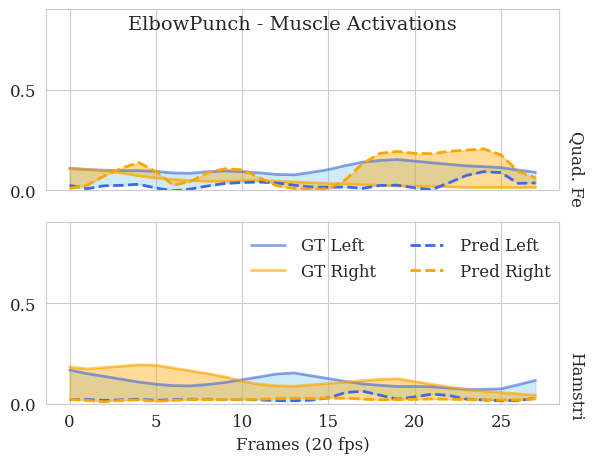

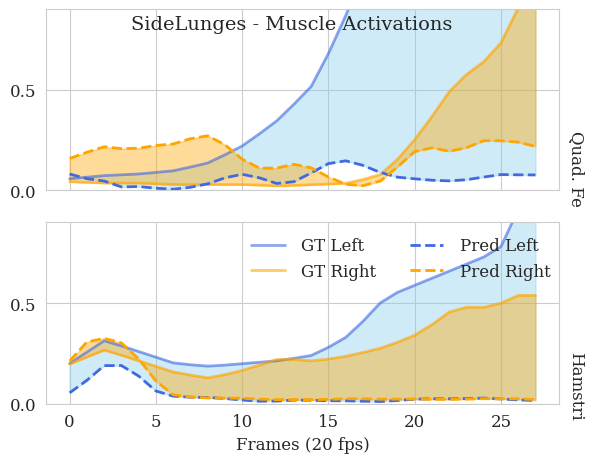

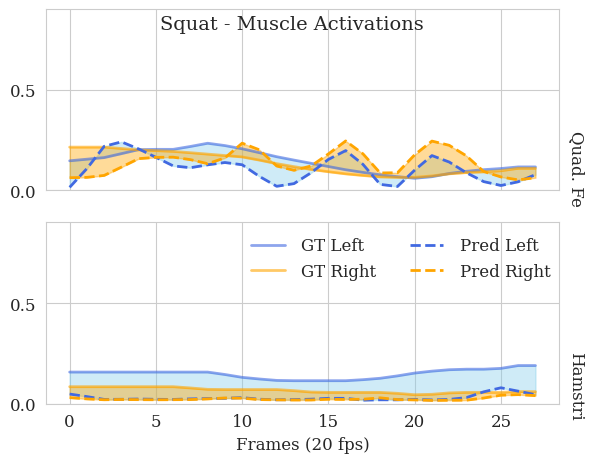

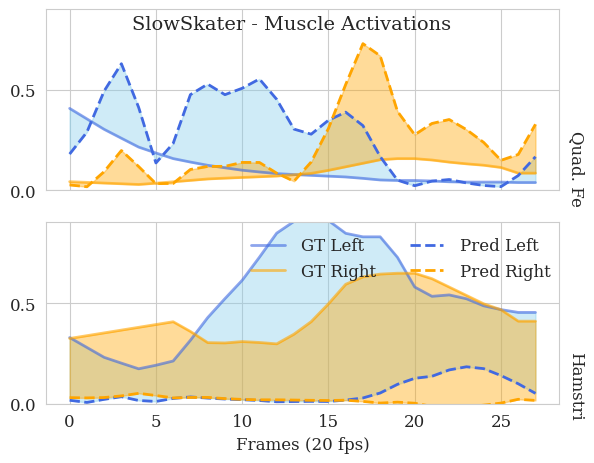

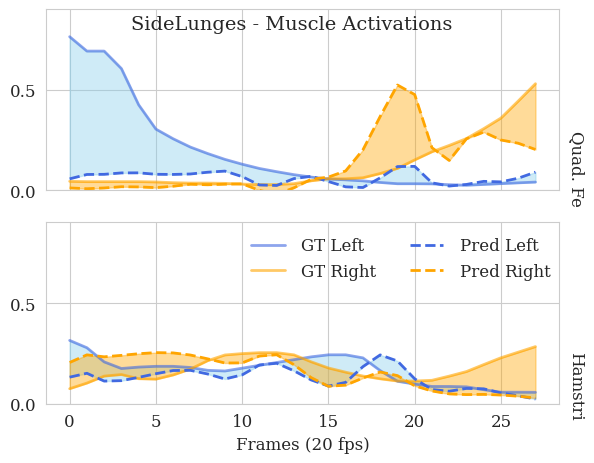

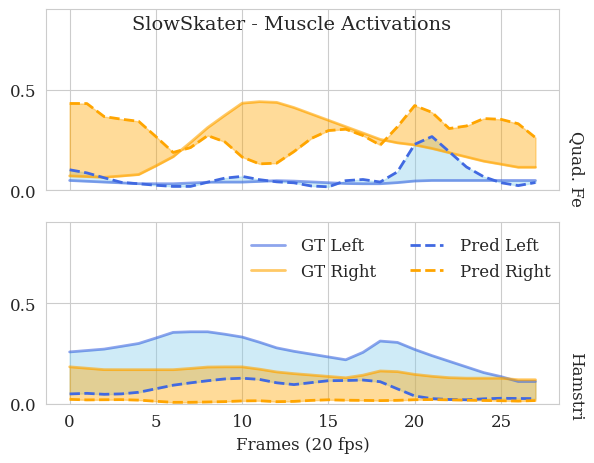

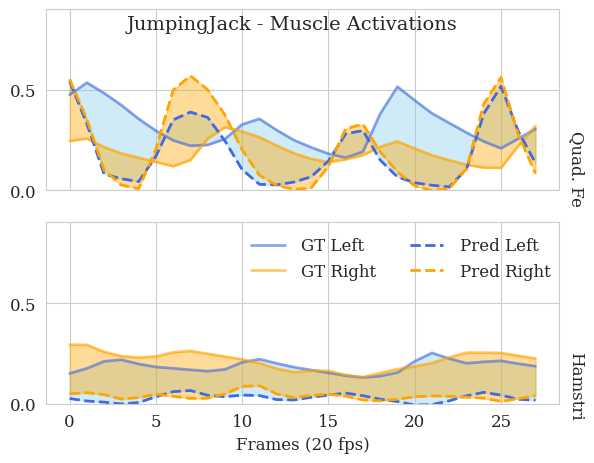

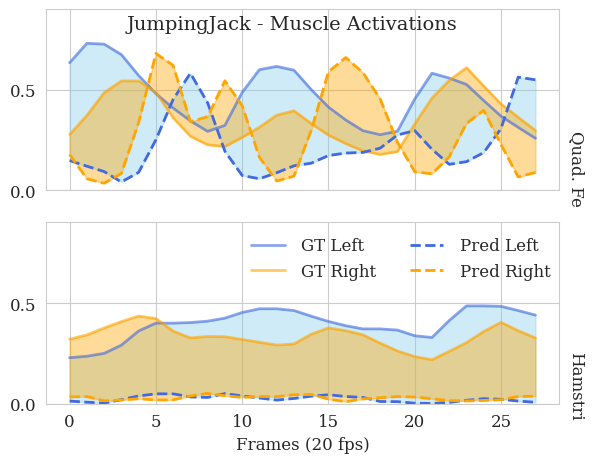

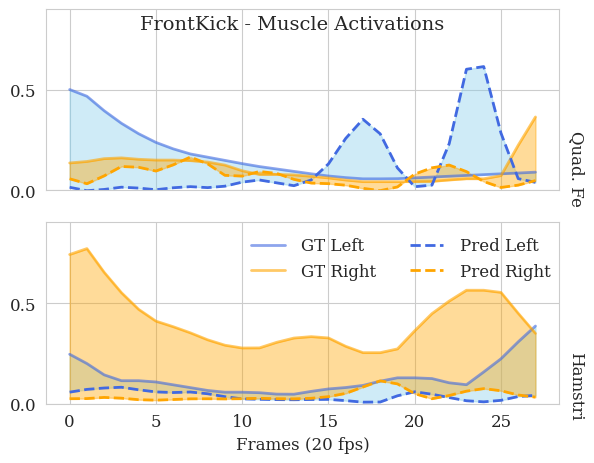

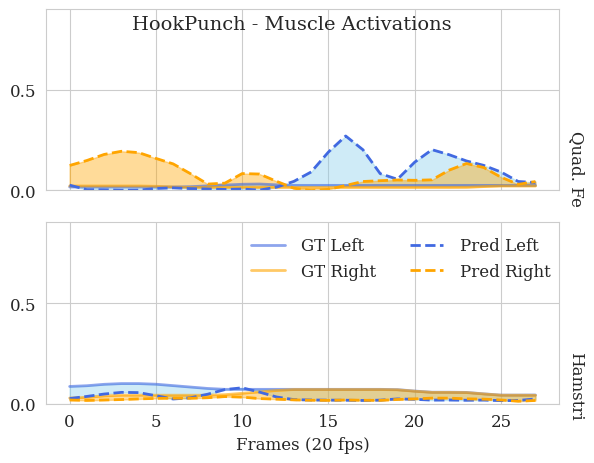

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_style(style="whitegrid")


# Set global plot parameters for consistent styling
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (6, 4.8),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)

MIA_SUBSET_TARGET = [
    "quadriceps_femoris_l",
    "hamstring_l",
    "quadriceps_femoris_r",
    "hamstring_r",
]

MUSCLE_NAMES = ["Quad. Fem. L", "Hamstring L", "Quad. Fem. R", "Hamstring R"]

keys = list(np.random.choice(list(avg_pred_weighted.keys()), 10, replace=False))

for key in keys:

    action = key.split("/")[1]

    gt = gt_data_match[key].values
    pred = avg_pred_weighted[key].values

    T, D = gt.shape
    plt.figure()

    counter = 0

    for li in range(0, int(len(MUSCLE_NAMES) / 2)):
        ri = li + int(len(MUSCLE_NAMES) / 2)  # Right index

        muscle_name_l = MUSCLE_NAMES[li]
        muscle_name_r = MUSCLE_NAMES[ri]

        counter += 1

        plt.subplot(int(D / 2), 1, counter)

        x = np.arange(len(gt[:, li]))
        x_new = np.linspace(x.min(), x.max(), len(x) * 10)

        gt_l = gt[:, li]
        gt_r = gt[:, ri]

        pred_l = pred[:, ri]
        # pred_l = interp1d(x, pred_l, kind="cubic")(x_new)

        pred_r = pred[:, li]

        plt.plot(gt_l, label=f"GT Left", linewidth=2, color="royalblue", alpha=0.6)
        plt.plot(gt_r, label=f"GT Right", linewidth=2, color="orange", alpha=0.6)

        plt.plot(pred_l, label=f"Pred Left", linestyle="--", linewidth=2, color="royalblue")
        plt.plot(pred_r, label=f"Pred Right", linestyle="--", linewidth=2, color="orange")

        plt.fill_between(range(len(gt_l)), gt_l, pred_l, color="skyblue", alpha=0.4)
        plt.fill_between(range(len(gt_r)), gt_r, pred_r, color="orange", alpha=0.4)
        plt.yticks([0, 0.5])
        plt.title(f"{muscle_name_l[:-4]}", rotation=-90, loc="right", x=1.05, y=-0.11)

        # plt.ylabel(f"Activation")
        # Hide x-axis for all but the last subplot
        if counter != int(D / 2):
            # plt.yticks([])
            # plt.gca().xaxis.set_ticks([])
            plt.gca().set_xticklabels([])
            plt.gca().xaxis.grid(True)  # Ensure x-axis grid is visible
        else:
            plt.xlabel("Frames (20 fps)")

        plt.ylim((0, 0.9))
        plt.grid(True)

    # plt.ylabel(f"Activation", y=2.2)
    plt.legend(loc="upper right", bbox_to_anchor=(1.013, 1.0), ncol=2, frameon=False, handletextpad=1)
    plt.tight_layout()
    plt.suptitle(f"{action} - Muscle Activations", fontsize=14, y=0.95)
    # plt.savefig(f"{sample_idx}_{action}.svg")
    plt.show()

In [95]:
import random

# ElbowPunch  FrontKick  FrontPunch  HighKick  HookPunch  JumpingJack  KneeKick  LegBack  LegCross  RonddeJambe  Running  Shuffle  SideLunges  SlowSkater  Squat
keys = [k for k in gt_data_match.keys() if "Squat" in k]
keys = random.sample(keys, k=5)
keys

['Subject2/Squat/118',
 'Subject6/Squat/287',
 'Subject5/Squat/109',
 'Subject6/Squat/102',
 'Subject3/Squat/138']

/tmp/ipykernel_2756815/1125309747.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_df = pred_df.rolling(window=10, center=True).mean().fillna(method="bfill").fillna(method="ffill")


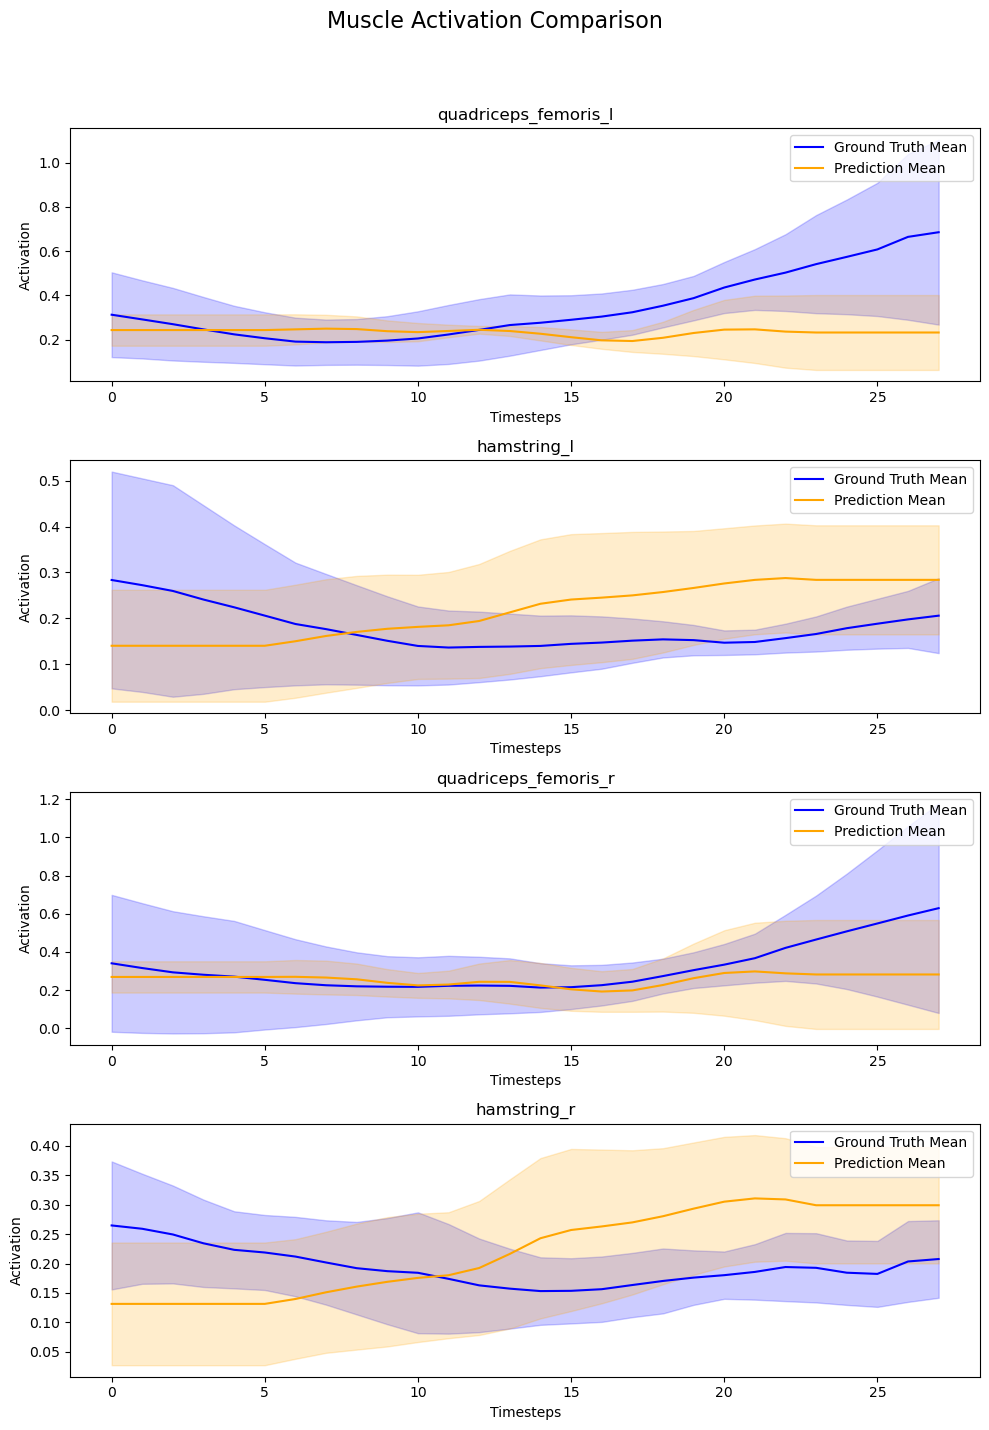

In [96]:
plot_muscle_activation(gt_data_match, avg_pred, keys=keys, mia_subset=MIA_SUBSET)